<a href="https://colab.research.google.com/github/lilika67/SmartGwiza_System/blob/main/Notebook/SmartGwizaNL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SmartGwiza Maize yield prediction system**

In [1]:
#  Importing Libraries
# This cell imports all necessary Python libraries for data processing, visualization, and machine learning.
# It also sets random seeds for reproducibility across NumPy, PyTorch, and Python's random module.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from io import StringIO

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
# Loading the Dataset
# This cell loads the maize yield dataset
# It prints the first few rows to verify successful loading.


df = pd.read_csv("maize_yieldNL.csv")
print("Dataset loaded successfully:")
print(df.head())

Dataset loaded successfully:
   Year  hg/ha_yield  pesticides_tonnes  avg_temp
0  1990      10252.0              157.0     19.39
1  1991      11556.0              107.0     19.22
2  1992      12250.0               97.0     19.54
3  1993      17400.0              127.4     19.53
4  1994      16750.0              157.8     19.55


# **Vizualization**

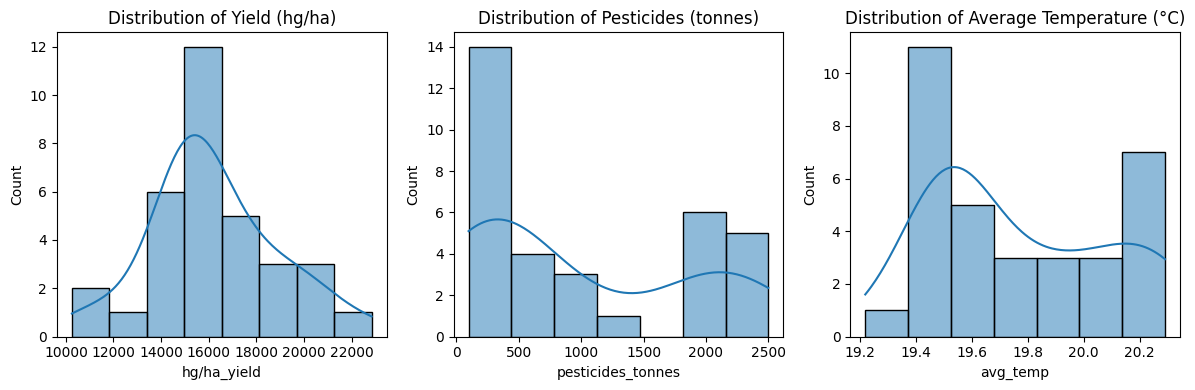

In [3]:
#  Visualizing Data Distributions
# This cell creates histograms with kernel density estimates for the yield, pesticides, and temperature features.
# It helps understand the distribution and spread of each variable.

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['hg/ha_yield'], kde=True)
plt.title('Distribution of Yield (hg/ha)')
plt.subplot(1, 3, 2)
sns.histplot(df['pesticides_tonnes'], kde=True)
plt.title('Distribution of Pesticides (tonnes)')
plt.subplot(1, 3, 3)
sns.histplot(df['avg_temp'], kde=True)
plt.title('Distribution of Average Temperature (°C)')
plt.tight_layout()
plt.show()

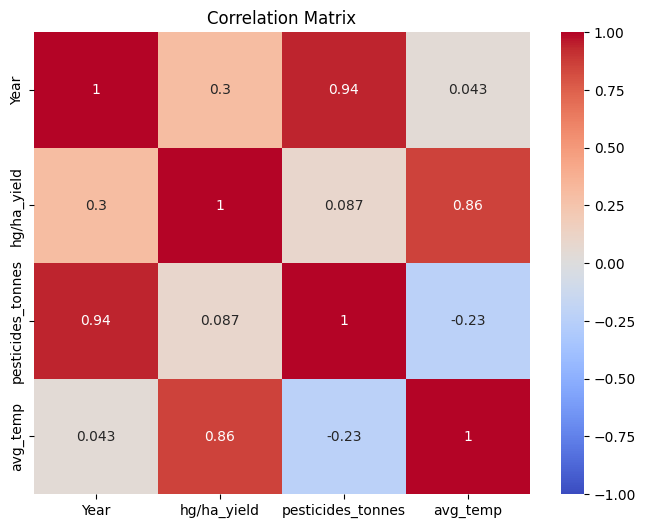

In [4]:
#  Visualizing Correlations
# This cell generates a heatmap of the correlation matrix to show relationships between variables.
# It highlights strong correlations, like between yield and temperature, or pesticides and year.

corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

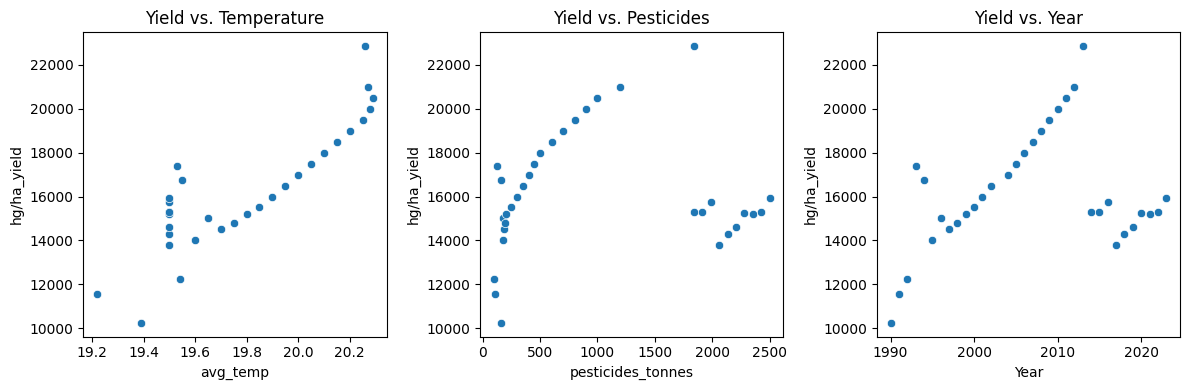

In [5]:
#  Visualizing Scatter Plots
# This cell creates scatter plots to explore relationships between yield and each feature (temperature, pesticides, year).
# It helps identify trends, such as the strong link between temperature and yield.

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(x='avg_temp', y='hg/ha_yield', data=df)
plt.title('Yield vs. Temperature')
plt.subplot(1, 3, 2)
sns.scatterplot(x='pesticides_tonnes', y='hg/ha_yield', data=df)
plt.title('Yield vs. Pesticides')
plt.subplot(1, 3, 3)
sns.scatterplot(x='Year', y='hg/ha_yield', data=df)
plt.title('Yield vs. Year')
plt.tight_layout()
plt.show()

# **Data Engineering**

In [6]:

# This cell prepares the data by selecting features, scaling them, and splitting into train/test sets.
# Features (Year, pesticides_tonnes, avg_temp) and target (hg/ha_yield) are scaled and converted to PyTorch tensors.

X = df[['Year', 'pesticides_tonnes', 'avg_temp']].values
y = df['hg/ha_yield'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(" Train shape:", X_train.shape, "Test shape:", X_test.shape)

 Train shape: (26, 3) Test shape: (7, 3)


# **Model Definition**

In [7]:
# This cell defines the three models: MaizeYieldNN (neural network), Linear Regression, and Polynomial Regression.
# Each model is set up for training and evaluation.

# MaizeYieldNN (Neural Network)
class MaizeYieldNN(nn.Module):
    def __init__(self):
        super(MaizeYieldNN, self).__init__()
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

nn_model = MaizeYieldNN()
nn_criterion = nn.MSELoss()
nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

# Linear Regression (placeholders for coefficients)
lin_coefficients = None

# Polynomial Regression (placeholders for coefficients)
poly_coefficients = None

# Model **Training**

In [8]:
# Neural Network Training
num_epochs = 500
batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))

for epoch in range(num_epochs):
    nn_model.train()
    for inputs, targets in train_loader:
        nn_optimizer.zero_grad()
        outputs = nn_model(inputs)
        loss = nn_criterion(outputs, targets)
        loss.backward()
        nn_optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f' Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


torch.save(nn_model.state_dict(), 'maize_yield_model.pth')


 Epoch [50/500], Loss: 0.0103
 Epoch [100/500], Loss: 0.0075
 Epoch [150/500], Loss: 0.4435
 Epoch [200/500], Loss: 0.0157
 Epoch [250/500], Loss: 0.0031
 Epoch [300/500], Loss: 0.3291
 Epoch [350/500], Loss: 0.0036
 Epoch [400/500], Loss: 0.1060
 Epoch [450/500], Loss: 0.1151
 Epoch [500/500], Loss: 0.0042


In [9]:
# Linear Regression Training
X_train_bias = np.c_[np.ones(X_train.shape[0]), X_train]
lin_coefficients, _, _, _ = np.linalg.lstsq(X_train_bias, scaler_y.inverse_transform(y_train), rcond=None)


In [10]:
# Polynomial Regression Training
def poly_features(X_scaled):
    x1, x2, x3 = X_scaled[:,0], X_scaled[:,1], X_scaled[:,2]
    return np.c_[np.ones(X_scaled.shape[0]), x1, x2, x3, x1**2, x2**2, x3**2, x1*x2, x1*x3, x2*x3]

X_train_poly = poly_features(X_train)
poly_coefficients, _, _, _ = np.linalg.lstsq(X_train_poly, scaler_y.inverse_transform(y_train), rcond=None)


In [11]:
import pickle


with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print("✓ Scalers saved successfully!")
print("Files created: scaler_X.pkl, scaler_y.pkl")

✓ Scalers saved successfully!
Files created: scaler_X.pkl, scaler_y.pkl


# **Model Evaluation**


 In this part we  evaluated all three models on the test set, computing R², MSE, and MAE metrics.

In [12]:
# Neural Network Evaluation
nn_model.eval()
with torch.no_grad():
    y_pred_nn_scaled = nn_model(X_test_tensor)
    y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled.numpy())
    y_test_orig = scaler_y.inverse_transform(y_test)
mse_nn = mean_squared_error(y_test_orig, y_pred_nn)
mae_nn = mean_absolute_error(y_test_orig, y_pred_nn)
r2_nn = r2_score(y_test_orig, y_pred_nn)

print("Neural Network Metrics:")
print(f"R² Score: {r2_nn:.3f}")
print(f"Mean Squared Error (MSE): {mse_nn:.0f}")
print(f"Mean Absolute Error (MAE): {mae_nn:.0f}")


Neural Network Metrics:
R² Score: 0.945
Mean Squared Error (MSE): 265886
Mean Absolute Error (MAE): 272


In [13]:
# Linear Regression Evaluation
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]
y_pred_lin = np.dot(X_test_bias, lin_coefficients)
mse_lin = mean_squared_error(y_test_orig, y_pred_lin)
mae_lin = mean_absolute_error(y_test_orig, y_pred_lin)
r2_lin = r2_score(y_test_orig, y_pred_lin)

print("\nLinear Regression Metrics:")
print(f"R² Score: {r2_lin:.3f}")
print(f"Mean Squared Error (MSE): {mse_lin:.0f}")
print(f"Mean Absolute Error (MAE): {mae_lin:.0f}")



Linear Regression Metrics:
R² Score: 0.931
Mean Squared Error (MSE): 338282
Mean Absolute Error (MAE): 395


In [14]:
# Polynomial Regression Evaluation
X_test_poly = poly_features(X_test)
y_pred_poly = np.dot(X_test_poly, poly_coefficients)
mse_poly = mean_squared_error(y_test_orig, y_pred_poly)
mae_poly = mean_absolute_error(y_test_orig, y_pred_poly)
r2_poly = r2_score(y_test_orig, y_pred_poly)

print("\nPolynomial Regression Metrics:")
print(f"R² Score: {r2_poly:.3f}")
print(f"Mean Squared Error (MSE): {mse_poly:.0f}")
print(f"Mean Absolute Error (MAE): {mae_poly:.0f}")


Polynomial Regression Metrics:
R² Score: 0.705
Mean Squared Error (MSE): 1434811
Mean Absolute Error (MAE): 967


# **Model Comparison**

we compared the metrics from all three models and saved the best model.


In [15]:
#  Model Comparison and Saving Best

print("Model Comparison:")
print(f"Neural Network: R²={r2_nn:.3f}, MSE={mse_nn:.0f}, MAE={mae_nn:.0f}")
print(f"Linear Regression: R²={r2_lin:.3f}, MSE={mse_lin:.0f}, MAE={mae_lin:.0f}")
print(f"Polynomial Regression: R²={r2_poly:.3f}, MSE={mse_poly:.0f}, MAE={mae_poly:.0f}")

best_model = 'maize_yield_model.pth'  # Neural Network is best (highest R², lowest MSE/MAE)
print(f"\nBest Model: Neural Network (saved as '{best_model}') with R²={r2_nn:.3f}, MSE={mse_nn:.0f}, MAE={mae_nn:.0f}.")

Model Comparison:
Neural Network: R²=0.945, MSE=265886, MAE=272
Linear Regression: R²=0.931, MSE=338282, MAE=395
Polynomial Regression: R²=0.705, MSE=1434811, MAE=967

Best Model: Neural Network (saved as 'maize_yield_model.pth') with R²=0.945, MSE=265886, MAE=272.


# Prediction **Function**

In [16]:

# This cell defines a function to predict maize yield for new inputs using the best model.


def predict_yield(year, pesticides_tonnes, avg_temp):
    # Defining training data ranges
    year_range = (1990, 2023)
    pesticides_range = (97, 2500)
    temp_range = (19.22, 20.29)

    # Validating and clip inputs with buffers
    year_clipped = max(min(year, year_range[1] + 5), year_range[0])
    pesticides_clipped = max(min(pesticides_tonnes, pesticides_range[1] * 1.2), pesticides_range[0])
    temp_clipped = max(min(avg_temp, temp_range[1] + 0.5), temp_range[0] - 0.5)


    if avg_temp < temp_range[0] - 0.5 or avg_temp > temp_range[1] + 0.5:
        print(f"Warning: Temperature {avg_temp}°C is outside training range ({temp_range[0]}-{temp_range[1]}°C). Clipped to {temp_clipped}°C.")
    if year < year_range[0] or year > year_range[1] + 5:
        print(f"Warning: Year {year} is outside training range ({year_range[0]}-{year_range[1]}+5). Clipped to {year_clipped}.")
    if pesticides_tonnes < pesticides_range[0] or pesticides_tonnes > pesticides_range[1] * 1.2:
        print(f"Warning: Pesticides {pesticides_tonnes} tonnes is outside training range ({pesticides_range[0]}-{pesticides_range[1]}*1.2). Clipped to {pesticides_clipped} tonnes.")

    nn_model.load_state_dict(torch.load('maize_yield_model.pth'))
    nn_model.eval()
    input_data = np.array([[year_clipped, pesticides_clipped, temp_clipped]])
    input_scaled = scaler_X.transform(input_data)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    with torch.no_grad():
        pred_scaled = nn_model(input_tensor)
        pred = scaler_y.inverse_transform(pred_scaled.numpy())
    return max(pred[0][0], 0)

# Example1 of prediction
example_pred = predict_yield(2024, 2600, 19.6)
print(f" Prediction for 2024 (2600 tonnes pesticides, 19.6°C) using Neural Network: {example_pred:.0f} hg/ha")

 Prediction for 2024 (2600 tonnes pesticides, 19.6°C) using Neural Network: 17943 hg/ha


In [17]:
# Example2 prediction
example_pred = predict_yield(2024, 2600, 20)
print(f" Prediction for 2024 (2600 tonnes pesticides, 20C) using Neural Network: {example_pred:.0f} hg/ha")

 Prediction for 2024 (2600 tonnes pesticides, 20C) using Neural Network: 22383 hg/ha
